In [1]:
import os
import sys
import tarfile
import numpy as np
from six.moves.urllib.request import urlretrieve
import scipy.io as sio
from six.moves import cPickle as pickle
import tensorflow as tf
from PIL import Image
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
        
        last_percent_reported = percent


def maybe_download(filename, expected_bytes, force=False, dirc=""):
    d = False
    if force or not os.path.exists(dirc + filename):
        print ('Attempting to download: ' + filename)
        d = True
        filename, _ = urlretrieve(url + filename, dirc + filename, reporthook=download_progress_hook)
        print ('\nDownload Complete!')
    if not d:
        filename = dirc + filename
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print ('Found and verified', filename)
    else:
        raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

In [3]:
train_file = maybe_download('train_32x32.mat', 182040794, dirc="data/") #"downloads/train_32x32.mat"
test_file = maybe_download('test_32x32.mat', 64275384, dirc="data/") #"downloads/test_32x32.mat"

('Found and verified', 'data/train_32x32.mat')
('Found and verified', 'data/test_32x32.mat')


In [4]:
train_dataset = sio.loadmat(train_file)
test_dataset = sio.loadmat(test_file)

train_data, train_labels = train_dataset['X'], train_dataset['y']
test_data, test_labels = test_dataset['X'], test_dataset['y']

print( 'Train data:', train_data.shape,', Train labels:', train_labels.shape )
print( 'Test data:', test_data.shape,', Test labels:', test_labels.shape )

('Train data:', (32, 32, 3, 73257), ', Train labels:', (73257, 1))
('Test data:', (32, 32, 3, 26032), ', Test labels:', (26032, 1))


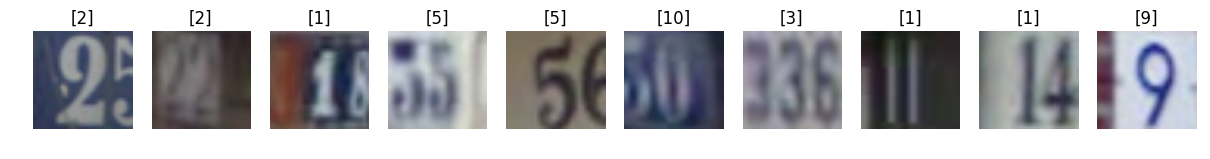

In [6]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(train_data[:,:,:,j])

In [7]:
# first we will normalize image data in range of -1 and 1.
train_data = train_data.astype('float32') / 128.0 - 1
test_data = test_data.astype('float32') / 128.0 - 1

# reshaping np array so that we can access data in CNN friendly format i.e. [i,:,:,:] from [:,:,:,i]
train_data = np.transpose(train_data, (3, 0, 1, 2))
test_data = np.transpose(test_data,(3, 0, 1, 2))

#chaning class labels range 1-10 to 0-9
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

# processing labels in CNN friendly format i.e. 1-hot-encoding
num_labels = 10
train_labels = train_labels[:,0]
test_labels = test_labels[:,0]
train_labels = (np.arange(num_labels) == train_labels[:, None]).astype(np.float32)
test_labels = (np.arange(num_labels) == test_labels[:, None]).astype(np.float32)

print 'Train data:', train_data.shape,', Train labels:', train_labels.shape
print 'Test data:', test_data.shape,', Test labels:', test_labels.shape

Train data: (73257, 32, 32, 3) , Train labels: (73257, 10)
Test data: (26032, 32, 32, 3) , Test labels: (26032, 10)


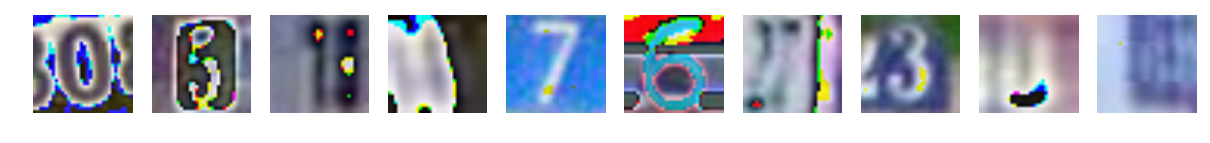

In [9]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    # we will not display labels here as 1-hot-encoding cannot be viewed properly in little place
    ax[i].imshow(train_data[j,:,:,:])

In [10]:
# creating dictionary to store trian and test data
svhn_datasets = {
    'train_dataset' : {
        'X': train_data,
        'y': train_labels
    },
    'test_dataset' : {
        'X': test_data,
        'y': test_labels
    }
}

data_file = 'pickles/svhn.pickle'

print 'saving pickle to %s' % data_file
with open(data_file, 'wb') as file:
    pickle.dump(svhn_datasets, file, protocol=pickle.HIGHEST_PROTOCOL)
    del svhn_datasets # to free up memory.

print 'pickle saved!'

saving pickle to pickles/svhn.pickle
pickle saved!


In [20]:
# lets load data from pickle file we previously stored
data_file = 'pickles/svhn.pickle' # redefined varaible in case you have completed above steps previously.
print 'Tring to load pickle from %s' % data_file
with open(data_file, 'rb') as file:
    svhn_datasets = pickle.load(file)
    train_dataset = svhn_datasets['train_dataset']
    test_dataset = svhn_datasets['test_dataset']
    del svhn_datasets # free up memory
print 'pickle loaded successfully!'

Tring to load pickle from pickles/svhn.pickle
pickle loaded successfully!


In [21]:
train_data = train_dataset['X']
train_labels = train_dataset['y']

test_data = test_dataset['X']
test_labels = test_dataset['y']

del train_dataset, test_dataset

print 'Test data:', test_data.shape,', Test labels:', test_labels.shape

Test data: (26032, 32, 32, 3) , Test labels: (26032, 10)


In [22]:
import scipy as si

def resizer(x):
    maxsize = (28, 28)
    x = si.misc.imresize(x, maxsize, interp = 'bilinear')
    return x    
i = 0
X_train = np.zeros((np.shape(train_data)[0], 28, 28, 3))
for row in train_data:
    X_train[i] = resizer(row)
    i+=1
print("New Train set size", X_train.shape)
X_test = np.zeros((np.shape(test_data)[0], 28, 28, 3))
i = 0
for row in test_data:
    X_test[i] = resizer(row)
    i+=1
print("New test set size", X_test.shape)

del train_data
del test_data

('New Train set size', (73257, 28, 28, 3))
('New test set size', (26032, 28, 28, 3))


In [23]:
new_X_train = X_train[10000:]
#new_X_train = np.mean(new_X_train,-1)
new_X_train = np.reshape(new_X_train, [-1, 28, 28, 3])
X_test = X_test
X_test = np.reshape(X_test, [-1, 28, 28, 3])
X_valid = X_train[:10000]
X_valid = np.reshape(X_valid, [-1, 28, 28, 3])
y_train = train_labels[10000:]
y_valid = train_labels[:10000]
y_test = test_labels
print('Training set', new_X_train.shape)
print('Training label', y_train.shape)
print('Validation set', X_valid.shape)
print('Validation label', y_valid.shape)
print('Test set', X_test.shape)
print('Test label', y_test.shape)

('Training set', (63257, 28, 28, 3))
('Training label', (63257, 10))
('Validation set', (10000, 28, 28, 3))
('Validation label', (10000, 10))
('Test set', (26032, 28, 28, 3))
('Test label', (26032, 10))


In [24]:
image_size = 28
num_labels = 10
num_channels = 3

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [25]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1], padding='SAME')

with graph.as_default():
    
    train_set = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    valid_set = tf.constant(X_valid)
    test_set = tf.constant(X_test)
    
    keep_prob = tf.placeholder(tf.float32)
    
    W_conv1 = weight_variable(
      [patch_size, patch_size, num_channels, depth])
    b_conv1 = bias_variable([depth])
    W_conv2 = weight_variable(
      [patch_size, patch_size, depth, depth])
    b_conv2 = bias_variable([depth])
    W_conv3 = weight_variable(
      [image_size // 4 * image_size // 4 * depth, num_hidden])
    b_conv3 = bias_variable([num_hidden])
    W_conv4 = weight_variable(
      [num_hidden, num_labels])
    b_conv4 = bias_variable([num_labels])
    
    def model(data):
        data = tf.cast(data, tf.float32)
        conv = conv2d(data, W_conv1)
        pool = max_pool_2x2(conv)
        hidden = tf.nn.relu(pool + b_conv1)
        conv = conv2d(hidden, W_conv2)
        pool = max_pool_2x2(conv)
        hidden = tf.nn.relu(pool + b_conv2)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, W_conv3) + b_conv3)
        drop = tf.nn.dropout(hidden, keep_prob)
        return tf.matmul(drop, W_conv4) + b_conv4

        


    logits = model(train_set)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, train_labels))
    
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(valid_set))
    test_prediction = tf.nn.softmax(model(test_set))

In [ ]:
num_steps = 2001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    batch_data = X_train[offset:(offset + batch_size), :, :, :]
    batch_labels = y_train[offset:(offset + batch_size), :]
    feed_dict = {train_set : batch_data, train_labels : batch_labels, keep_prob: 1.0}
    feed_dict_w_drop = {train_set : batch_data, train_labels : batch_labels, keep_prob: 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict_w_drop)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(feed_dict=feed_dict), y_valid))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(feed_dict=feed_dict), y_test))
        

Initialized
Minibatch loss at step 0: 212.871338
Minibatch accuracy: 31.2%
Validation accuracy: 19.3%
Minibatch loss at step 100: 2.183407
Minibatch accuracy: 31.2%
Validation accuracy: 19.3%
Minibatch loss at step 200: 2.222689
Minibatch accuracy: 18.8%
